SRN 230713176 <br>
ST2195 Coursework <br>
Part 2 (c)

## Question (c) <br> 
For each year, fit a logistic regression model for the probability of diverted US flights using as many features as possible from attributes of the departure date, the scheduled departure and arrival times, the coordinates and distance between departure and planned arrival airports, and the carrier. Visualize the coefficients across years.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
# read csv file
airports = pd.read_csv("airports.csv")

In [3]:
# using necessary columns to save memory
cols = ['Year','Month','DayOfWeek', 'DayofMonth',
        'CRSDepTime','CRSArrTime','Origin',
        'Diverted','Distance', 'Dest', 'UniqueCarrier']

In [4]:
df_1 = pd.read_csv("2000.csv", usecols=cols, encoding='ISO-8859-1')
df_2 = pd.read_csv("2001.csv", usecols=cols, encoding='ISO-8859-1')
df_3 = pd.read_csv("2002.csv", usecols=cols, encoding='ISO-8859-1')
df_4 = pd.read_csv("2003.csv", usecols=cols, encoding='ISO-8859-1')
df_5 = pd.read_csv("2004.csv", usecols=cols, encoding='ISO-8859-1')

In [5]:
dfs = pd.concat([df_1, df_2, df_3, df_4, df_5], ignore_index=True)

In [6]:
dfs = dfs.dropna(subset=['CRSDepTime', 'Year', 'Month', 'DayofMonth'])

In [7]:
dfs.to_parquet('flight datac.parquet', index=False)

In [3]:
df = pd.read_parquet('flight datac.parquet')

In [4]:
# question specifies US flights
df_us = df[df['UniqueCarrier'] == 'US'].copy()

In [5]:
# merge airport locations with flight records
df_us = df_us.merge(airports, left_on='Dest', right_on='iata', how='left').rename(columns={'lat': 'Dest_lat', 'long': 'Dest_long'})
df_us = df_us.merge(airports, left_on='Origin', right_on='iata', how='left').rename(columns={'lat': 'Origin_lat', 'long': 'Origin_long'})

In [6]:
# select columns to use
columns_to_use = ['Year', 'Month', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
                'Distance', 'Origin_lat', 'Origin_long', 'Dest_lat', 'Dest_long', 'Diverted']

In [7]:
df_us = df_us[columns_to_use]
df_us.dropna(inplace=True)

In [8]:
# store coefficients for each year
years = sorted(df_us['Year'].unique())
all_coefficients = {}
feature_names = ['Month', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime', 'Distance', 'Origin_lat', 'Origin_long', 'Dest_lat', 'Dest_long']

In [10]:
# Train the model for each year (2000-2004)
for year in years:
    
    # filter data for each year
    df_year = df_us[df_us['Year'] == year].copy()

    X = df_year[feature_names] # features
    y = df_year['Diverted'] # target
    
    if y.sum() == 0:
        print(f"Warning: no diverted flights in {year}")
        continue
    
    preprocessor = ColumnTransformer(
        transformers = [('num', StandardScaler(), feature_names)] # preprocessing and model training
    )

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(max_iter=1000, random_state=42))]) # preprocessing data then fitting a logistic regression model
    
    # split data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # fit model
    clf.fit(X_train, y_train)

    # store coefficients
    coeffs = clf.named_steps['classifier'].coef_[0]
    all_coefficients[year] = coeffs
    
    # show model performance
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    print(f"Year {year} - Train accuracy: {train_score:.4f}, Test accuracy: {test_score:.4f}")
    print(f"Diverted flights: {y.sum()} out of {len(y)} ({y.sum()/len(y)*100:.2f}%)\n")

Year 2000 - Train accuracy: 0.9968, Test accuracy: 0.9966
Diverted flights: 2450 out of 748624 (0.33%)

Year 2001 - Train accuracy: 0.9977, Test accuracy: 0.9976
Diverted flights: 1569 out of 688748 (0.23%)

Year 2002 - Train accuracy: 0.9987, Test accuracy: 0.9987
Diverted flights: 663 out of 511664 (0.13%)

Year 2003 - Train accuracy: 0.9985, Test accuracy: 0.9986
Diverted flights: 610 out of 411956 (0.15%)

Year 2004 - Train accuracy: 0.9982, Test accuracy: 0.9983
Diverted flights: 764 out of 419919 (0.18%)



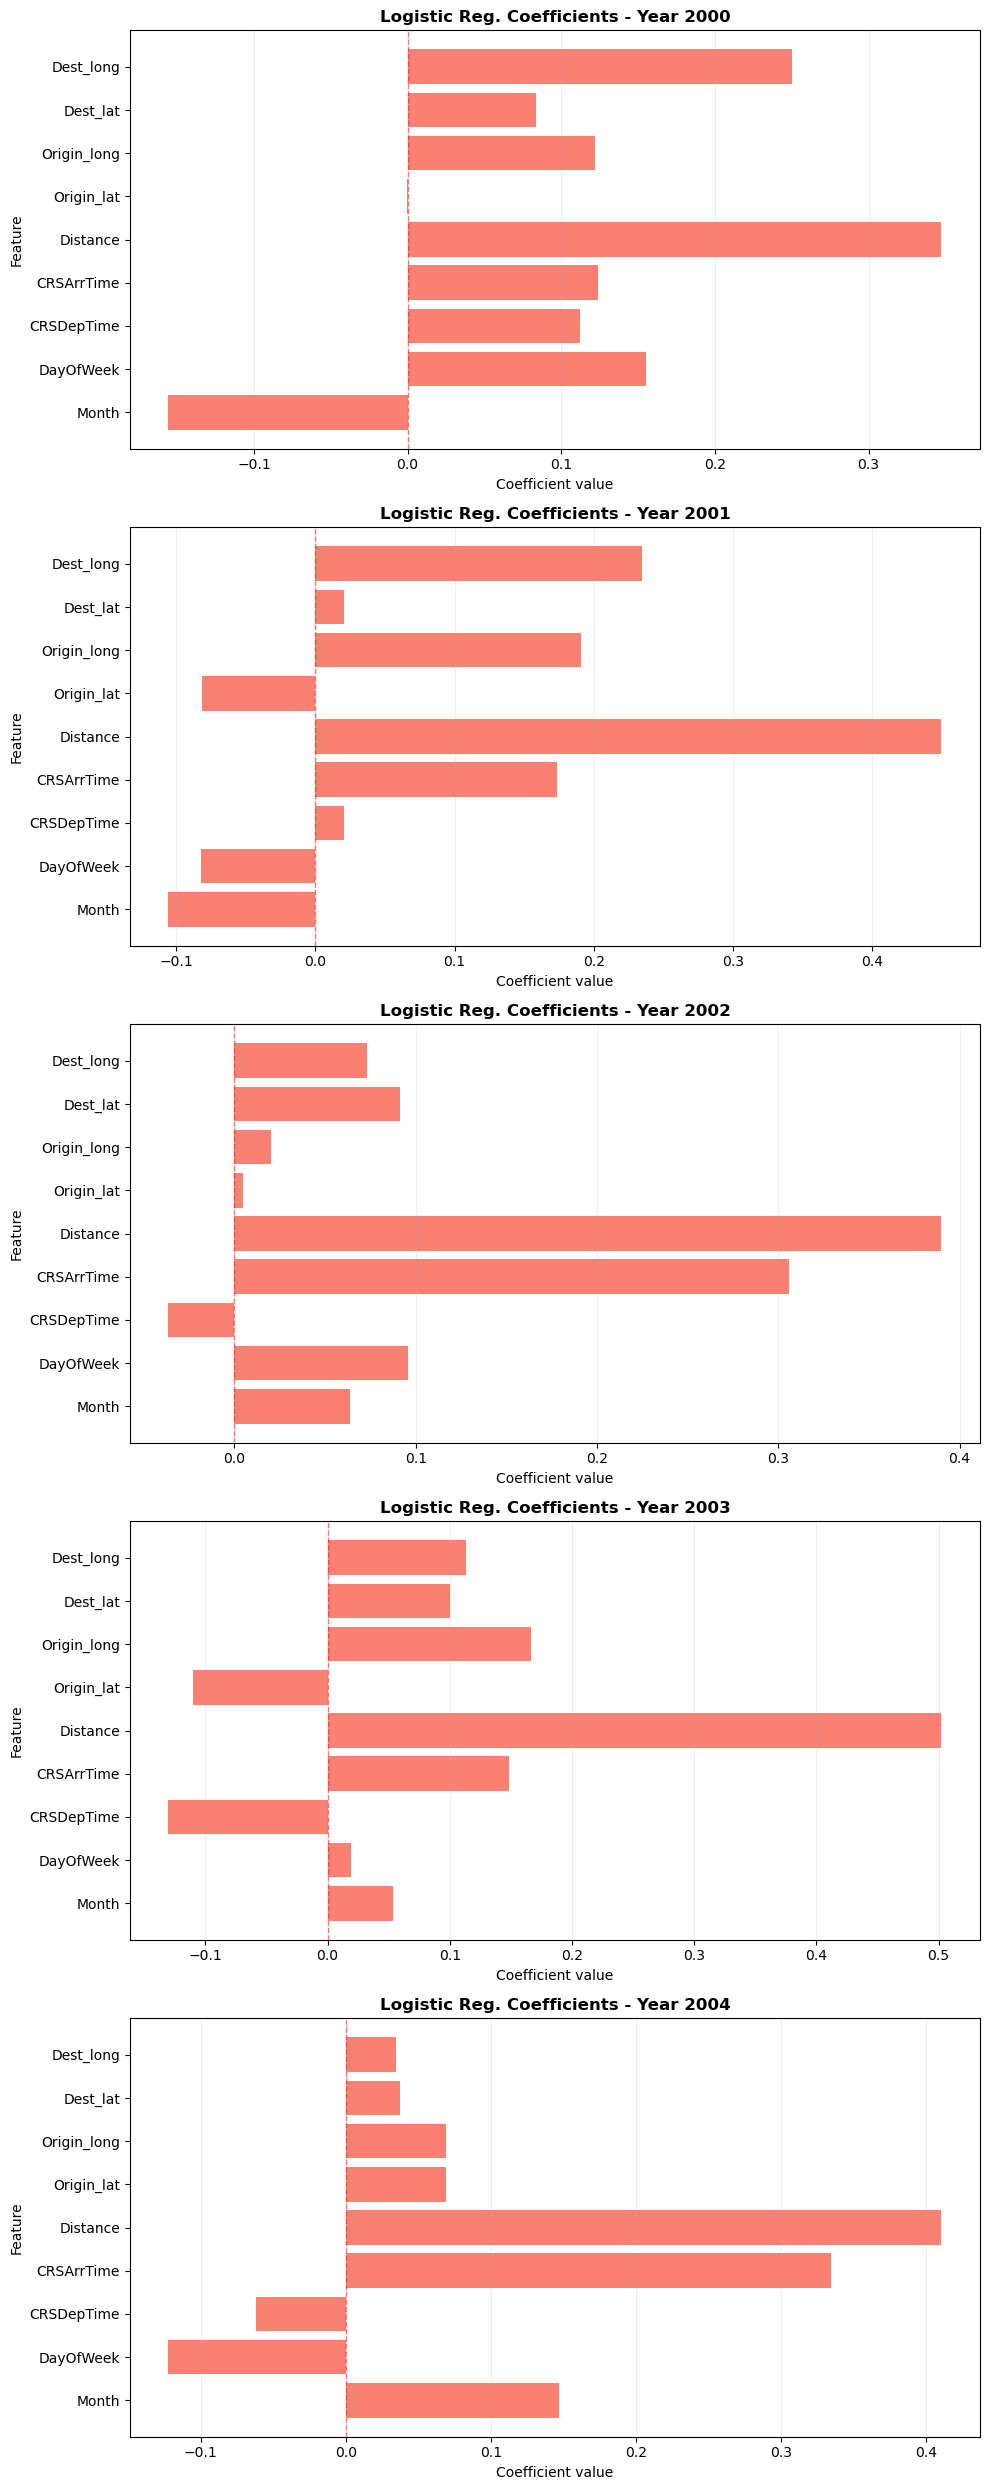

In [12]:
# visualizing the results

fig, axes = plt.subplots(len(all_coefficients), 1, figsize=(10, 5*len(all_coefficients)))

if len(all_coefficients) == 1:
    axes = [axes]

for idx, (year, coefs) in enumerate(sorted(all_coefficients.items())):
    axes[idx].barh(feature_names, coefs, color='salmon')
    axes[idx].set_xlabel('Coefficient value', fontsize=10)
    axes[idx].set_ylabel('Feature', fontsize=10)
    axes[idx].set_title(f'Logistic Reg. Coefficients - Year {year}', fontsize=12, fontweight='bold')
    axes[idx].axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[idx].grid(axis='x', alpha=0.2)

plt.tight_layout()
plt.savefig('coeffs_year.png', dpi=300, bbox_inches='tight')
plt.show()

### Coefficients comparison across years

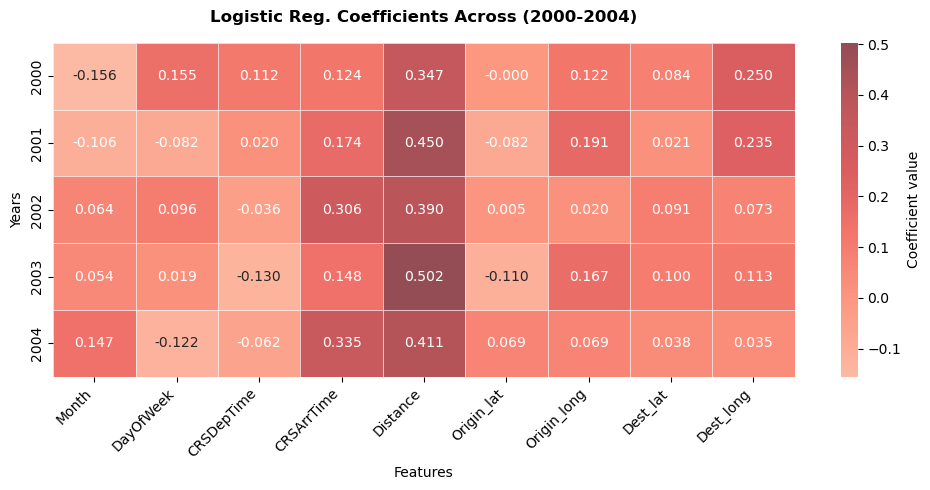

In [17]:
df_coeffs = pd.DataFrame(all_coefficients, index=feature_names).T

# visualization
plt.figure(figsize=(10,5))
sns.heatmap(df_coeffs, annot=True, fmt='.3f', cmap='Reds', alpha=0.7, center=0, cbar_kws={'label': 'Coefficient value'}, linewidths=0.5)
plt.title('Logistic Reg. Coefficients Across (2000-2004)', fontsize=12, fontweight='bold', pad=15)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Years', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('coeffs_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Conclusion
Coefficient summary statistics across years:

In [26]:
df_coeffs.describe()

,Month,DayOfWeek,CRSDepTime,CRSArrTime,Distance,Origin_lat,Origin_long,Dest_lat,Dest_long
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.000632,0.013168,-0.019222,0.217220,0.420022,-0.023586,0.113775,0.066782,0.141203
std,0.126423,0.116689,0.091156,0.096144,0.059008,0.072165,0.069928,0.035326,0.096611
min,-0.155639,-0.122306,-0.130204,0.123934,0.347402,-0.109992,0.020127,0.020743,0.034864
25%,-0.105644,-0.082200,-0.061904,0.148161,0.389909,-0.081771,0.069049,0.037643,0.073207
50%,0.053707,0.019460,-0.036431,0.173712,0.410679,-0.000277,0.122294,0.083830,0.113089
75%,0.063782,0.095733,0.020367,0.305619,0.449801,0.004789,0.166757,0.091212,0.234669
max,0.146956,0.155155,0.112063,0.334675,0.502321,0.069320,0.190648,0.100481,0.250184


Feature importance: how strongly they influence the model (on average)

In [34]:
avg_abs_coeff = df_coeffs.abs().mean().sort_values(ascending=False)
print(avg_abs_coeff.round(4))

Distance       0.4200
CRSArrTime     0.2172
Dest_long      0.1412
Origin_long    0.1138
Month          0.1051
DayOfWeek      0.0950
CRSDepTime     0.0722
Dest_lat       0.0668
Origin_lat     0.0532
dtype: float64
